<a href="https://colab.research.google.com/github/luckysouthchou/pytorch_udemy/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision


  Using cached https://files.pythonhosted.org/packages/19/5e/23dcc0ce3cc2abe92efd3cd61d764bee6ccdf1b667a1fb566f45dc249953/Pillow-7.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms



In [0]:
#image = (image - mean) / std
'''If you read the documentation here 872, you will see that both parameters are “Sequences for each channel”. Color images have three channels (red, green, blue), therefore you need three parameters to normalize each channel. The first tuple (0.5, 0.5, 0.5) is the mean for all three channels and the second (0.5, 0.5, 0.5) is the standard deviation for all three channels.'''

transform =  transforms.Compose([transforms.Resize ((28, 28)),
                                #resize it to 28 by 28, because the imgae may be 1000 by 1000 or other scale, we need to make sure and using one standerd
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                                ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#training = False .>>> in order to validate the model in the end 

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size =100, shuffle = False)

In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  #1, 28, 28 >> 28, 28, 1 (1 is channel) (C, H, W)(channel, height, weight)
  #denormalization
  #print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  #small than0, become 0, bigger than 1, become 1: .clip()
  return image

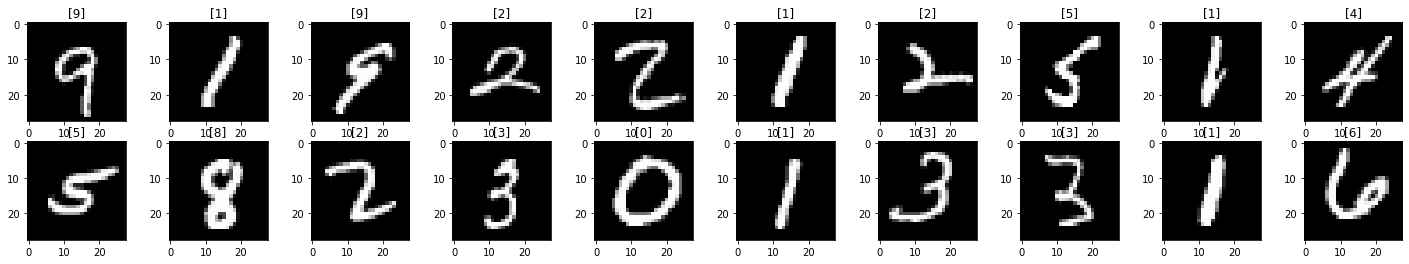

In [5]:
#For example, such a dataset, when called iter(dataset), could return a stream of data reading from a database, a remote server, or even logs generated in real time.
dataiter  = iter(training_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize = (25, 4))
#weight, height of the figure(25, 4)
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])
  

In [6]:
class Classfier(nn.Module):
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return x

model = Classfier(784, 125, 65, 10)
model


Classfier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
#we can reset the learning rates to 0.001 even 0.0001to have a good prediction

In [8]:
epochs = 5
running_loss_history = []
#store loss of every epoch
running_correct_history = []
#accuracy of every epoch
val_running_loss_history = []
val_running_correct_history = []
#store validation loss , and validation loss correction to a empty array
for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  #inistiate accuract value = 0.00
  val_running_loss = 0.0
  val_running_correct = 0.0


  for inputs, labels in training_loader: 
    inputs = inputs.view(inputs.shape[0], -1)
    #1, 784(1 channel, 28 * 28), make image 1 dimentional  
    outputs = model(inputs)
    #model using linear first, then using softmax to transfer the number into probabiloities, if the model is more sinple. softmax can be sigmoid function to transfer the number into probability
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    #return the index of the maximum probability value for that image
    running_corrects += torch.sum(preds == labels.data)

    running_loss += loss.item()
    #running loss: loss plus per batch

  else:
    #validation!
    with torch.no_grad():
      #set all grad flags to be false to save the memory

      for val_inputs, val_labels  in validation_loader:
      #validation process
        val_inputs = val_inputs.view(inputs.shape[0], -1)
        #1, 784(1 channel, 28 * 28), make image 1 dimentional  
        val_outputs = model(val_inputs)
        #model using linear first, then using softmax to transfer the number into probabiloities, if the model is more sinple. softmax can be sigmoid function to transfer the number into probability
        val_loss = criterion(val_outputs, val_labels)
        #do not need to pred and zero_grad() and backward and step, because it's validation step. it has their own labels correctly
        
        
        _, val_preds = torch.max(val_outputs, 1)
        #return the index of the maximum probability value for that image
        val_running_correct += torch.sum(val_preds == val_labels.data)

        val_running_loss += val_loss.item()
        #running loss: loss plus per batch



    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    #epoch_loss : loss of every epoch
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)


    #validation 
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_epoch_acc = val_running_correct.float()/len(validation_loader)

    val_running_loss_history.append(val_epoch_loss)
    val_running_correct_history.append(val_epoch_acc)
    print('epoch:',(e+1))
    #print test datse set out comes with loss and accuracy
    print('training loss: {:.4f}'.format(epoch_loss))
    print('trainig accuracy: {:.4f}'.format(epoch_acc.item()))
    #print validation 
    print('val_training loss: {:.4f}'.format(val_epoch_loss))
    print('val_trainig accuracy: {:.4f}'.format(val_epoch_acc.item()))

epoch: 1
training loss: 0.9524
trainig accuracy: 76.5067
val_training loss: 0.4170
val_trainig accuracy: 89.1300
epoch: 2
training loss: 0.3755
trainig accuracy: 89.5200
val_training loss: 0.3250
val_trainig accuracy: 90.7700
epoch: 3
training loss: 0.3181
trainig accuracy: 90.8600
val_training loss: 0.2861
val_trainig accuracy: 91.6100
epoch: 4
training loss: 0.2862
trainig accuracy: 91.7483
val_training loss: 0.2634
val_trainig accuracy: 92.5500
epoch: 5
training loss: 0.2613
trainig accuracy: 92.3967
val_training loss: 0.2453
val_trainig accuracy: 92.7700


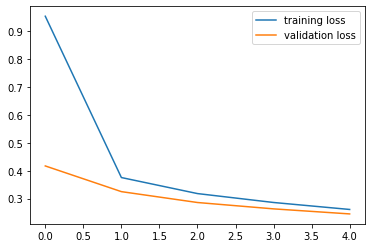

In [9]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()

In [10]:
!pip3 install pillow==4.0.0

import PIL.ImageOps

  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.5.0 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [0]:
#to see is the plot of accuracy has convergency 

In [0]:
#this graph is fluctuated, so reset the learning rates to a more minor vakue 0.01>>>> 0.001>>>>>0.0001, and run the program again

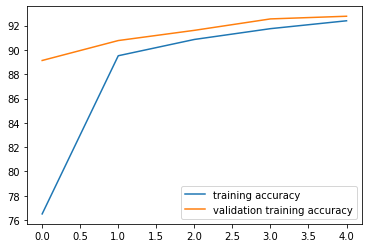

In [13]:
plt.plot(running_correct_history, label = 'training accuracy')
plt.plot(val_running_correct_history, label = 'validation training accuracy')
plt.legend()

<Response [200]>


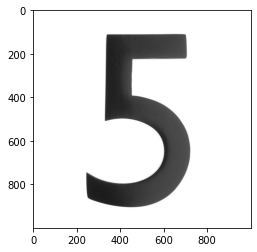

In [14]:
import requests

from PIL import Image
#PIL:python image library
#using a image from internet
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)
print(response)

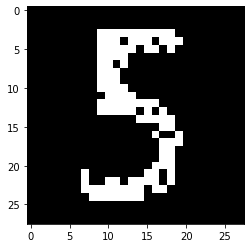

In [15]:
img = PIL.ImageOps.invert(img)
#change background color form white to black because our test data is black background, we need to confirm that
img = img.convert('1')
#trasnform ima from 1000 by 1000 to 28 by 28
img = transform(img)
#make sure to resieze image to 28 by 28 and from numpy array to tensor format
plt.imshow(im_convert(img))

In [16]:
img = img.view(img.shape[0], -1)
#1, 784(1 channel, 28 * 28), make image 1 dimentional  
output = model(img )
#model using linear first, then using softmax to transfer the number into probabiloities, if the model is more sinple. softmax can be sigmoid function to transfer the number into probability
_, pred = torch.max(output, 1)
#return the index of the maximum probability value for that image
print(pred.item())

5


ERROR! Session/line number was not unique in database. History logging moved to new session 71


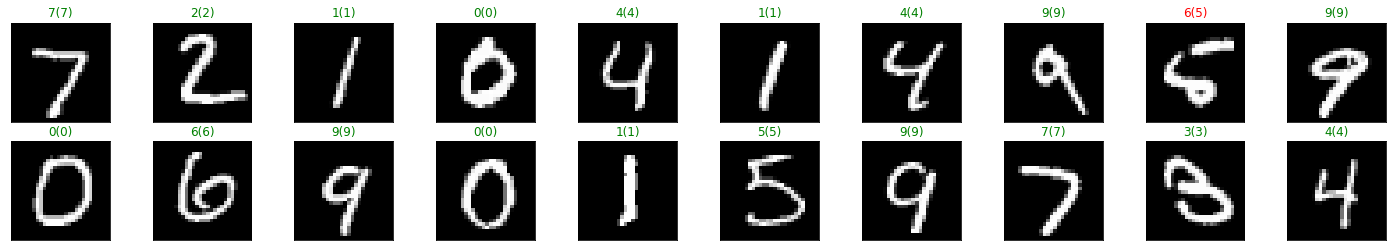

In [22]:
#For example, such a dataset, when called iter(dataset), could return a stream of data reading from a database, a remote server, or even logs generated in real time.
dataiter  = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize = (25, 4))

#weight, height of the figure(25, 4)
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title('{}({})'.format(str(preds[idx].item()), str(labels[idx].item())), color=('green' if preds[idx]==labels[idx] else 'red'))
